In [1]:
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from random import shuffle
import random
import glob
from skimage.transform import resize
#from PIL import Image
import os
from model import *
# from keras.models import Model
# from keras.layers import Input, Dense
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation
# from keras.optimizers import SGD
# from keras.utils import np_utils
# from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
# from keras.optimizers import SGD
# from keras.layers.normalization import BatchNormalization
# from keras.models import Model
# from keras import initializers
# from keras.engine import Layer, InputSpec
# from keras import backend as K
# import keras
# from resnet152 import ResNet152
from keras.preprocessing import image
# from keras.applications.imagenet_utils import preprocess_input, decode_prediction
from keras.utils import to_categorical
import numpy as np


from collections import defaultdict
import itertools
from tqdm import tqdm
import time
import shutil


Using TensorFlow backend.


In [2]:
num_classes = 10

In [3]:
def load_dataset(dataset_path):
    folders = os.listdir(dataset_path)
    X = []
    y = []
    image_size = (256, 256)
    for i, folder in enumerate(folders):
        paths = glob.glob(os.path.join(dataset_path, folder+'/*[(.png)(.jpg)]'))
        label = np.ones(len(paths), dtype=np.int8) * i
        
        X += paths
        if (len(y)<1):
            y = label
        else:
            y = np.concatenate( (y, label), axis=0)
    
    images = np.array([cv2.imread(image_name) for image_name in X])    
    return images, to_categorical(y, num_classes)

def load_dataset_finetune(dataset_path):
    paths = glob.glob(os.path.join(dataset_path + '/*.png'))
    # 3 is for houses, 14 is for orchards
    label = np.ones(len(paths), dtype=np.int8) * 14
#     label = np.ones(len(paths), dtype=np.int8) * 3
    
    images = np.array([cv2.imread(image_name) for image_name in paths])    
    return images, to_categorical(label, num_classes)

def batch_generator(data_X, data_y, batch_size):
    indexes = np.array(range(len(data_y)))
    n = len(indexes)
    while True:
        batch_start = 0
        batch_end = batch_size
        np.random.shuffle(indexes)
        while batch_start < n:
            index = []
            batch_y = []
            y = []
            index = indexes[batch_start:batch_end]
            batch_x = np.array([data_X[i] for i in index])
            batch_y = np.array([data_y[i] for i in index])
            yield batch_x, batch_y
            batch_start += batch_size   
            batch_end += batch_size


def plot_confusion_matrix(cm, classes, ylabel, xlabel,
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.grid()
    plt.title('Transitions from {} to {}'.format(ylabel, xlabel))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [4]:
# model_name = 'resNet152'
# dataset_path = '/media/waseem/3D0A87CA7D9EC477/M.Bhimra/mohbat_resnet/FINAL DATASET/dataset/houses'
model_name = 'resNet152_retrain_less'
dataset_path = '/Users/arsalan/Desktop/SRP Stuff/TrainingTesting/places/resizingAll'

In [31]:
X, y = load_dataset(dataset_path)
print ('Size of dataset:', len(y))
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Size of dataset: 5706
(5706, 256, 256, 3)


Display dataset stats

0 kiln 639
1 ground 629
2 grass 630
3 houses 635
4 densetrees 635
5 farms 634
6 blackfarms 652
7 roads 635
8 parking 617


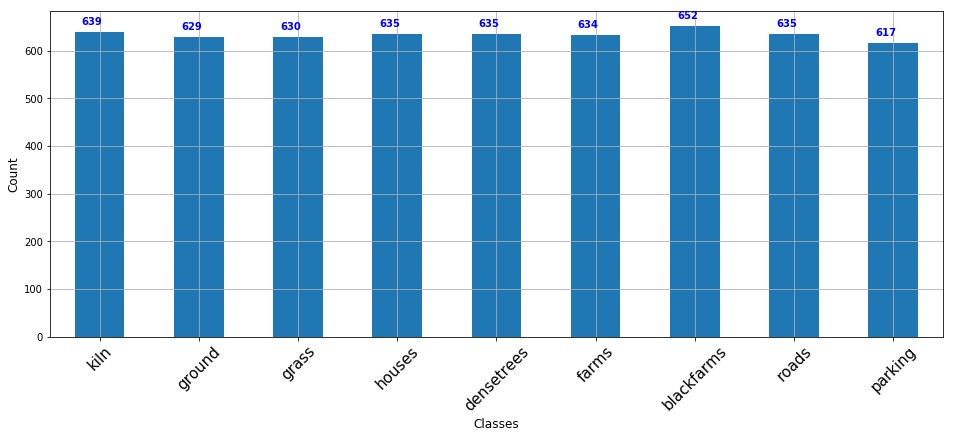

In [33]:
folders = os.listdir(dataset_path)
names, counts = [], []
for i, folder in enumerate(folders):
    dir_path = os.path.join(dataset_path, folder)
    images = os.listdir(dir_path)
    names.append(folder)
    counts.append(len(images))
    print(i, folder, len(images))
df = pd.DataFrame(data={'Name': names, 'Count': counts})
ax = df.plot(kind='bar', xticks=counts, grid=True, legend=False, figsize=(16,6))
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(np.arange(len(names)), names, rotation=45, fontsize=15)
for i, v in enumerate(counts):
    ax.text(i-.18, v+15, str(v), color='blue', fontweight='bold')
plt.show()

In [37]:
batch_size = 256
train_gen = batch_generator(X_train, y_train, batch_size)
test_gen = batch_generator(X_test, y_test, batch_size)

In [5]:
from resNet import *
input_shape=(256, 256, 3)
from keras.models import Sequential
# The '-1' is because we add a new class for finetuning
model = resNet(input_shape, num_classes, model_type='resnet_152')
model.load_weights(model_name+'.h5')
# model.load_weights('resNet152 (another copy).h5')

# # FINE TUNING HERE
# top_model = Sequential()
# top_model.add(Dense(input_shape=model.layers[-2].output_shape, units=num_classes, rnel
# kernel_initializer="he_normal", activation="softmax"))

# model.layers.pop()
# model.outputs = [model.layers[-1].output]
# model.layers[-1].outbound_nodes = []

# model = Model(inputs=model.inputs, outputs=top_model(model.outputs[0]))
# # for layer in model.layers[:-1]:
# #     layer.trainable = False

model.summary()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print('accuracy')

#plot_model(model, to_file='model.png')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

accuracy


Train ResNet-152 network using "fit_generator"

In [ ]:
checkpoint = ModelCheckpoint(model_name+'.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./', batch_size=batch_size, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.00001)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=2, mode='auto')
cvslogger = keras.callbacks.CSVLogger(model_name+'.csv', separator=',', append=True)
 
nb_epoch = 200
callbacks = [checkpoint, reduce_lr, earlystop, cvslogger, tensorboard]
train_steps = int(len(y_train)//batch_size)
val_steps = int(len(y_test)//batch_size)
history = model.fit_generator(train_gen, train_steps, epochs=nb_epoch, verbose=1, 
                    max_queue_size=2, validation_data=test_gen, 
                    validation_steps=val_steps, shuffle=True,
                    workers=1, use_multiprocessing= False, 
                    initial_epoch=0, callbacks=callbacks)

#model.fit(x=X[0:100], y=y[0:100], batch_size=64, epochs=2, verbose=1, callbacks=callbacks, 
#          validation_split=0.2, shuffle=True,initial_epoch=0)


Epoch 1/200


# sanity check

In [6]:
model.evaluate_generator(test_gen, steps=len(X_test)//batch_size)

NameError: name 'test_gen' is not defined

In [9]:
# test_images_dir = 'lhr/newtask'
test_images_dir = '/Users/arsalan/Desktop/SRP Stuff/TrainingTesting/places/training_zoomLevel_17'

# results_dir = 'results_lahore_17_with_old_wets_attempt2'
results_dir = '/Users/arsalan/Desktop/SRP Stuff/TrainingTesting/places/results/training_zoomLevel_17'
if not os.path.exists(results_dir):
    print('Creating new results directory "{}"'.format(results_dir))
    os.mkdir(results_dir)
im_dir = os.path.join(results_dir, 'images')
if not os.path.exists(im_dir):
    os.mkdir(im_dir)

#for file in os.listdir(test_images_dir):
#    curr_name, curr_ext = os.path.splitext(file)
 #   print(curr_name[:-1])
 #   break
#    new_name = curr_name[:-1]
#    os.rename(os.path.join(test_images_dir, file), os.path.join(test_images_dir, new_name+curr_ext))

########################################################
########### RENAMING DONE IN DOWNLOAD SCRIPT ###########
########################################################

Creating new results directory "/Users/arsalan/Desktop/SRP Stuff/TrainingTesting/places/results/training_zoomLevel_17"


Testing the model and creating result files

In [10]:
## print('Waiting'len(images)len(images)len(images), end='', flush=True)len(images)
# while True:
    
 #   if len(os.listdir(test_images_dir)) != 544244:
 #      time.sleep(10*60)
 #       print('.', end='', flush=True)
 #       continue


# if os.path.exists(os.path.join(results_dir, 'houses.txt')) or os.path.exists(os.path.join(results_dir, 'test.csv')):
#     raise OSError('Result files already present, this script will append to the existing data.')
    
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms', 14: 'orchard'}
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms'}
# label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'mosque', 8: 'oiltanks', 9: 'orchard', 10: 'parking', 11: 'parks', 12: 'ponds', 13: 'roads', 14: 'tennis'}
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)

# # Resuming check
# try:
#     with open(os.path.join(results_dir, 'last_file_done.txt'), 'r') as f:
#         loop_index = int(f.read())
#     print('Resuming from file index "{}"'.format(loop_index))
# except FileNotFoundError:
#     loop_index = 0
#     print('Starting fresh from file index "0"')

filenames = os.listdir(test_images_dir)

# # Missing images check
# try:
#     with open(os.path.join(results_dir, 'missing_images.txt'), 'r') as f:
#         missing_images = [name.strip() for name in f.readlines()]
#     print('Continuing with {} missing images.'.format(len(missing_images)))
# except FileNotFoundError:
#     missing_images = []
#     print('Starting fresh with empty missing images list')

for img_name in tqdm(filenames):
#     extt=img_name.split('.')[1]
    orig_name, extt = os.path.splitext(img_name)
    if(extt == '.jpg'):
        img_orig = cv2.imread(os.path.join(test_images_dir, img_name), cv2.IMREAD_COLOR)
        # To catch corrupt images
        if type(img_orig) == type(None):
            print('Skipping an image "{}"'.format(img_name))
        #    missing_images.append(img_name)
            continue
            
        img = np.expand_dims(img_orig, axis=0)
        class_name = img_name.split('.')[0]

        pred = model.predict(img, verbose=0)
    #    preds.append((pred.argmax(), pred.max(), class_name))
        
#         src = os.path.join(test_images_dir, img_name)
#         dst = os.path.join(results_dir, 'images', orig_name+'_'+label_names[pred.argmax()]+extt)
#         shutil.copyfile(src, dst)
#         print(img_name, dst)
        
#         break

#         lng,lat = os.path.splitext(img_name)[0].split('_')


#         lat, lng= os.path.splitext(img_name)[0].split('_')
        lat,lng = os.path.splitext(img_name)[0].split()
        y_tiles.append(lat)
        x_tiles.append(lng)

        # Append to individual results files on each itteration
        for i, label in label_names.items():
            file_path = os.path.join(results_dir, label+'.txt')
            label_probs[label].append(pred[0, i])
            with open(file_path, 'a') as f:
                f.write('{} {} {}\n'.format(lat, lng, pred[0, i]))
#         # Append to full result file on every 1000 itterations
#         #if loop_index % 1000 == 0:
#         d = {'y_tile': y_tiles, 'x_tile': x_tiles}
#         d.update(label_probs)
#         final_df = pd.DataFrame(data=d)
#         final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
        # Resuming 
        #with open('last_file_done.txt', 'w') as f:
         #   f.write(str(loop_index))
        # Write names of corrupted files for later use
        #with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
           # for i in missing_images:
           #     f.write('{}\n'.format(i))
        #loop_index += 1

        top3_inds = np.argsort(pred)
        top3_inds = np.flip(top3_inds, axis=1)
        top3_labels = [ label_names[i] for ia in top3_inds for i in ia ]
        top3_probs = pred[0, top3_inds]
#     print(top3_labels)

        for n in range(num_classes):
            top_label_probs['label'+str(n+1)].append(top3_labels[n])
            top_label_probs['prob'+str(n+1)].append(top3_probs[0, n])

# Append to full result file last time
d = {'lat': y_tiles, 'lng': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
# final_df

# Write names of corrupted files for later use
#with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
#    for i in missing_images:
#        f.write('{}\n'.format(i))

d = {'lat': y_tiles, 'lng': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['lat', 'lng', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)
# sorted_df.head()

# preds = sorted(preds, key=lambda x: x[0])
# for p_class, p_prob, truth in preds:
#     got_it = label_names[p_class] == truth
#     print('{}\tPrediction: {}\tTruth: {}\tProb: {}'.format(got_it, label_names[p_class], truth, p_prob))
#     break

100%|██████████| 639/639 [05:34<00:00,  1.91it/s]


import shutil

for n in filenames[:200]:
    src = os.path.join(test_images_dir, n)
    dst = os.path.join('orchard_copy', n)
    shutil.copyfile(src, dst)

In [22]:
def transition_probs(start, end, filename):
    imstart = cv2.imread(os.path.join(start, filename), cv2.IMREAD_COLOR)
    imend = cv2.imread(os.path.join(end, filename), cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(imstart, cv2.COLHourOR_BGHourR2RGB))
    plt.imshow(cv2.cvtColor(imend, cv2.COLOR_BGR2RGB))
    
    if imstart is None or imend is None:
        raise OSError('Image "{}" not found in either "{}" or "{}"'.format(filename, start, end))
    
    imstart = np.expand_dims(imstart, axis=0)
    imend = np.expand_dims(imend, axis=0)

    predstart = model.predict(imstart, verbose=0)
    predend = model.predict(imend, verbose=0)

    return predstart.T * predend

Generate confusion matrices for each year

In [24]:
    
    
    
# dir11, dir13, dir17 = 'matilhr11', 'matilhr13', 'matilhr17'
dir11, dir13, dir17 = 'alpha', 'beta', 'gamma'

fig = plt.figure(figsize=(8,8))

filenames = os.listdir(dir11)
for filename in tqdm(filenames):
        from11to13 = transition_probs(dir11, dir13, filename)
        plot_confusion_matrix(from11to13, label_names.values(), '2011', '2013')
        plt.savefig(os.path.join('11_13', filename), bbox_inches='tight')

        plt.clf()
        from13to17 = transition_probs(dir13, dir17, filename)
        plot_confusion_matrix(from13to17, label_names.values(), '2013', '2017')
        plt.savefig(os.path.join('13_17', filename), bbox_inches='tight')

        plt.clf()
        from11to17 = transition_probs(dir11, dir17, filename)
        plot_confusion_matrix(from11to17, label_names.values(), '2011', '2017')
        plt.savefig(os.path.join('11_17', filename), bbox_inches='tight')
        plt.clf()



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'alpha'

Merge confusion matrices by year

In [26]:
    
dir11, dir13, dir17 = '11_13', '13_17', '11_17'
out_dir = 'confusion_matrices'

fig = plt.figure(figsize=(8*3,8))


filenames = os.listdir(dir11)
for filename in tqdm(filenames):
        im1 = cv2.imread(os.path.join(dir11, filename), cv2.IMREAD_COLOR)
        im1 = cv2.resize(im1, (560, 560))
        im2 = cv2.imread(os.path.join(dir13, filename), cv2.IMREAD_COLOR)
        im2 = cv2.resize(im2, (560, 560))
        im3 = cv2.imread(os.path.join(dir17, filename), cv2.IMREAD_COLOR)
        im3 = cv2.resize(im3, (560, 560))

        vis = np.concatenate((im1, im2), axis=1)
        vis = np.concatenate((vis, im3), axis=1)

        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB), aspect='auto')
        plt.axis('off')
        plt.savefig(os.path.join(out_dir, filename), bbox_inches='tight', dpi=400)
        plt.clf()



FileNotFoundError: [WinError 3] The system cannot find the path specified: '11_13'